# Problem & Solution
*With the development of technology, it is possible to predict the temperature of the ground surface, reducing damage to crops. However, there is a blind spot, and the temperature in this blind spot is predicted to further reduce crop damage. A model to predict the surface temperature by season was developed, and the **CatBoostRegressor** model was used. An ensemble with other boosting-type models was performed, but it was used as a single model due to overfitting.*

# Data set

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#데이터셋
train = pd.read_csv("/content/drive/MyDrive/Weather/data/surface_tp_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Weather/data/surface_tp_test.csv")

train.drop(['Unnamed: 0'],1,inplace=True)
test.drop(['Unnamed: 0'],1,inplace=True)

<ipython-input-2-f91854753b00>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train.drop(['Unnamed: 0'],1,inplace=True)
<ipython-input-2-f91854753b00>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test.drop(['Unnamed: 0'],1,inplace=True)


In [ ]:
#검증데이터셋
ss_spring = pd.read_excel("/content/drive/MyDrive/Weather/data/subminssionUser.xlsx",sheet_name="SPRING")
ss_summer = pd.read_excel("/content/drive/MyDrive/Weather/data/subminssionUser.xlsx",sheet_name="SUMMER")
ss_autumn = pd.read_excel("/content/drive/MyDrive/Weather/data/subminssionUser.xlsx",sheet_name="AUTUMN")
ss_winter = pd.read_excel("/content/drive/MyDrive/Weather/data/subminssionUser.xlsx",sheet_name="WINTER")

# Run

In [ ]:
!pip install optuna catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00


In [ ]:
# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import re

#machine learning
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
from catboost import CatBoostRegressor

#변수명 변경
train.columns = ['stn','year','mmddhh','ta','td','hm','ws','rn','re','ww','ts','si','ss','sn']
test.columns  = ['stn','year','mmddhh','ta','td','hm','ws','rn','re','ww','si','ss','sn']

#값 변경 (업데이트)
train['rn'].replace([1.8, 3,3, 5.3,1.95,30.3,623.5], -99.9, inplace=True)
test['rn'].replace([1.8, 3,3, 5.3,1.95,30.3,623.5], -99.9, inplace=True)

#타입 변경
train['stn'] = train['stn'].astype("object")
test['stn'] = test['stn'].astype("object")

#날짜
train['mmddhh'] = train['mmddhh'].astype(str)
train['mmddhh'] = train['mmddhh'].apply(lambda x : '0' + x if len(x) == 5 else x)

train['month'] = train['mmddhh'].str.slice(0, 2)
train['day'] = train['mmddhh'].str.slice(2,4)
train['hour'] = train['mmddhh'].str.slice(4,6)

test['mmddhh'] = test['mmddhh'].astype(str)
test['mmddhh'] = test['mmddhh'].apply(lambda x : '0' + x if len(x) == 5 else x)

test['month'] = test['mmddhh'].str.slice(0, 2)
test['day'] = test['mmddhh'].str.slice(2,4)
test['hour'] = test['mmddhh'].str.slice(4,6)

train['month'] = train['month'].str.lstrip('0')
train['day'] = train['day'].str.lstrip('0')
train['hour'] = train['hour'].apply(lambda x: str(int(x)))

test['month'] = test['month'].str.lstrip('0')
test['day'] = test['day'].str.lstrip('0')
test['hour'] = test['hour'].apply(lambda x: str(int(x)))

# #수치형 변수로 변환
def astyp(data,column):
  for _ in column:
    data[_] = data[_].astype('int32')

astyp(train, ['mmddhh'])
astyp(test, ['mmddhh'])

#희소 레이블 묶기
train['ww']=train['ww'].apply(lambda x: 'Else' if x in ['F','S','X'] else x)
test['ww']=test['ww'].apply(lambda x: 'Else' if x in ['F','S','X'] else x)

#이상치 제거
train = train.drop(train[(train['ta'] < -80) | (train['ts'] < -80)].index)

#NaN으로 처리
train[(train == -99.9) | (train == -99)] = np.nan
test[(test == -99.9) | (test == -99)] = np.nan

#검증 데이터셋 변수명 변경
seasons = [ss_spring, ss_summer, ss_autumn, ss_winter]
column_names = ['stn', 'year', 'mmddhh', 'ts']


for season in seasons:
    season.columns = column_names

# 봄

In [ ]:
#계절별 훈련 데이터셋, 테스트 데이터셋 생성
train_spring = train[train['mmddhh'].isin(ss_spring['mmddhh'])]
test_spring = test[test['mmddhh'].isin(ss_spring['mmddhh'])]

#차분
for col in ['ss']:
    train_spring[col + '_diff_1'] = train_spring[col].diff()
    test_spring[col + '_diff_1'] = test_spring[col].diff()

#시차이동
for col in ['si','ta','ss']:
    train_spring[col + '_shift_1'] = train_spring[col].shift(1)
    test_spring[col + '_shift_1'] = test_spring[col].shift(1)

#
for col in ['ta','re']:
    train_spring[col + '_rolling'] = train_spring[col].rolling(window=24).mean()
    test_spring[col + '_rolling'] = test_spring[col].rolling(window=24).mean()

# #확장
for col in ['si','re','ws','rn','sn']:
    train_spring[col + '_expanding'] = train_spring[col].expanding(min_periods=24).mean()
    test_spring[col + '_expanding'] = test_spring[col].expanding(min_periods=24).mean()

# train_summer = train[train['mmddhh'].isin(ss_summer['mmddhh'])]
# # train_summer.fillna(train_summer[num_cols].median(axis=0), inplace=True)

# train_autumn = train[train['mmddhh'].isin(ss_autumn['mmddhh'])]
# # train_autumn.fillna(train_autumn[num_cols].median(axis=0), inplace=True)

# train_winter = train[train['mmddhh'].isin(ss_winter['mmddhh'])]
# # train_winter.fillna(train_winter[num_cols].median(axis=0), inplace=True)

# test_summer = test[test['mmddhh'].isin(ss_summer['mmddhh'])]
# test_summer = pd.merge(ss_summer, test_summer, on=['stn','year','mmddhh'])
# test_summer = test_summer.drop(['ts'],1)
# # test_summer.fillna(train_summer[num_cols].median(axis=0), inplace=True)

# test_autumn = test[test['mmddhh'].isin(ss_autumn['mmddhh'])]
# # test_autumn.fillna(train_autumn[num_cols].median(axis=0), inplace=True)

# test_winter = test[test['mmddhh'].isin(ss_winter['mmddhh'])]
# # test_winter.fillna(train_winter[num_cols].median(axis=0), inplace=True) #winter의 경우 vot model 을 사용한다.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
target = 'ts'
original_features = ['ta', 'si_shift_1', 'si', 'ta_shift_1', 'mmddhh', 'stn', 'month', 'year', 'hour', 'si_expanding', 're_expanding', 'ws_expanding', 'ss_diff_1', 'ss_shift_1', 'ta_rolling', 'rn_expanding', 'ss', 'td', 'sn_expanding', 're_rolling']
result_list = []
def spring_score_model(model, features_used, label=None):
    score_list = []
    oof = np.zeros_like(train_spring[target])
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    for fold, (idx_tr, idx_val) in enumerate(kf.split(train_spring[original_features], train_spring[target])):
        X_train_spring = train_spring.iloc[idx_tr][features_used]
        X_valid = train_spring.iloc[idx_val][features_used]
        y_train_spring = train_spring.iloc[idx_tr][target]
        y_valid = train_spring.iloc[idx_val][target]

        num_cols = X_train_spring.select_dtypes(exclude='object').columns.tolist()
        cat_cols = X_train_spring.select_dtypes(include='object').columns.tolist()

        encoding = LabelEncoder()

        for col in cat_cols:
            X_train_spring[col] = encoding.fit_transform(X_train_spring[col])
            X_valid[col] = encoding.transform(X_valid[col])

        model.fit(X_train_spring, y_train_spring)
        tscore = mean_absolute_error(y_train_spring, model.predict(X_train_spring))
        y_valid_pred = model.predict(X_valid)
        score = mean_absolute_error(y_valid, y_valid_pred)
        print(f" Fold {fold} : tscore = {tscore:.3f} score = {score:.3f}")
        oof[idx_val] = y_valid_pred
        score_list.append(score)

    score = sum(score_list) / len(score_list)
    print(f" Avg. MAE score : {score:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, score, oof))

XGB 과적합

In [ ]:
%%time
spring_score_model(CatBoostRegressor(random_state=42, silent=True, task_type='GPU'), features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.853 score = 0.903
 Fold 1 : tscore = 0.855 score = 0.896
 Fold 2 : tscore = 0.855 score = 0.911
 Fold 3 : tscore = 0.851 score = 0.896
 Fold 4 : tscore = 0.852 score = 0.904
 Fold 5 : tscore = 0.855 score = 0.900
 Fold 6 : tscore = 0.854 score = 0.893
 Fold 7 : tscore = 0.853 score = 0.902
 Fold 8 : tscore = 0.858 score = 0.891
 Fold 9 : tscore = 0.853 score = 0.900
 Avg. MAE score : 0.900
CPU times: user 59.3 s, sys: 23.1 s, total: 1min 22s
Wall time: 58.6 s


In [ ]:
%%time
#xgboost의 경우, 결측값 채우기전이 후보다 좋다
spring_score_model(XGBRegressor(random_state=42, tree_method='gpu_hist'), features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.816 score = 0.919
 Fold 1 : tscore = 0.835 score = 0.923
 Fold 2 : tscore = 0.830 score = 0.934
 Fold 3 : tscore = 0.824 score = 0.924
 Fold 4 : tscore = 0.830 score = 0.932
 Fold 5 : tscore = 0.830 score = 0.938
 Fold 6 : tscore = 0.825 score = 0.914
 Fold 7 : tscore = 0.825 score = 0.930
 Fold 8 : tscore = 0.831 score = 0.927
 Fold 9 : tscore = 0.830 score = 0.938
 Avg. MAE score : 0.928
CPU times: user 16.4 s, sys: 264 ms, total: 16.7 s
Wall time: 16.8 s


In [ ]:
from sklearn.ensemble import VotingRegressor

vot_model = VotingRegressor(estimators=[('XGBoost',XGBRegressor(random_state=42, tree_method='gpu_hist')),('CatBoost',CatBoostRegressor(random_state=42, silent=True,task_type='GPU'))])

In [ ]:
%%time
spring_score_model(vot_model, features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.795 score = 0.866
 Fold 1 : tscore = 0.810 score = 0.871
 Fold 2 : tscore = 0.804 score = 0.882
 Fold 3 : tscore = 0.799 score = 0.868
 Fold 4 : tscore = 0.802 score = 0.876
 Fold 5 : tscore = 0.804 score = 0.880
 Fold 6 : tscore = 0.801 score = 0.863
 Fold 7 : tscore = 0.800 score = 0.875
 Fold 8 : tscore = 0.805 score = 0.867
 Fold 9 : tscore = 0.801 score = 0.876
 Avg. MAE score : 0.873
CPU times: user 1min 19s, sys: 25.8 s, total: 1min 44s
Wall time: 1min 20s


In [ ]:
# test set 예측
encoding = LabelEncoder()

num_cols = train_spring[original_features].select_dtypes(exclude='object').columns.tolist()
cat_cols = train_spring[original_features].select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    train_spring[col] = encoding.fit_transform(train_spring[col])
    test_spring[col] = encoding.fit_transform(test_spring[col])

X = train_spring.drop(['ts'],1)
y = train_spring.ts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [ ]:
# model = CatBoostRegressor(random_state=42, silent=True, task_type='GPU')
# model.fit(X_train, y_train)

# def plot_feature_importance(importance, names, model_type, figsize=(10,8)):
#     feature_importance = np.array(importance)
#     feature_names = np.array(names)

#     data = {'feature_names':feature_names, 'feature_importance':feature_importance}
#     fi_df = pd.DataFrame(data)

#     fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#     plt.figure(figsize=figsize)

#     sns.barplot(x=fi_df['feature_importance'],y=fi_df['feature_names'])

#     plt.title(model_type + 'FEATURE IM..')
#     plt.xlabel("FEATURE IM..")
#     plt.ylabel('FEATURE NAME')

# plot_feature_importance(model.feature_importances_, X_train.columns, 'CAT',figsize=(8,16))

# importances = model.feature_importances_
# feature_names = X_train.columns


# feature_importances = pd.DataFrame({'Feature_names': feature_names, 'Importance': importances})


# sorted_df = feature_importances.sort_values(by='Importance', ascending=False)


# top_10_features = sorted_df.head(20)
# top_10_features_list = top_10_features['Feature_names'].tolist()

# print(top_10_features_list)

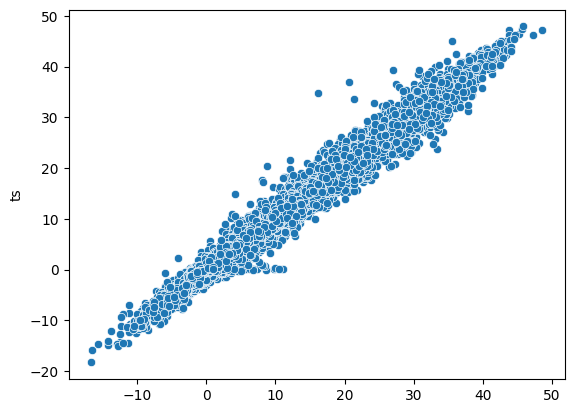

In [ ]:
X_train = X_train[original_features]
X_test = X_test[original_features]

model = CatBoostRegressor(random_state=42,silent=True, task_type='GPU')
model.fit(X_train, y_train)
pred = model.predict(X_test)
sns.scatterplot(x=pred, y=y_test)
final_spring_pred = model.predict(test_spring[original_features])

# 여름

In [ ]:
#데이터셋
train = pd.read_csv("/content/drive/MyDrive/Weather/data/surface_tp_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Weather/data/surface_tp_test.csv")

train.drop(['Unnamed: 0'],1,inplace=True)
test.drop(['Unnamed: 0'],1,inplace=True)

In [ ]:
# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import re

#machine learning
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
from catboost import CatBoostRegressor

#변수명 변경
train.columns = ['stn','year','mmddhh','ta','td','hm','ws','rn','re','ww','ts','si','ss','sn']
test.columns  = ['stn','year','mmddhh','ta','td','hm','ws','rn','re','ww','si','ss','sn']

#값 변경 (업데이트)
train['rn'].replace([1.8, 3,3, 5.3,1.95,30.3,623.5], -99.9, inplace=True)
test['rn'].replace([1.8, 3,3, 5.3,1.95,30.3,623.5], -99.9, inplace=True)

#타입 변경
train['stn'] = train['stn'].astype("object")
test['stn'] = test['stn'].astype("object")

#날짜
train['mmddhh'] = train['mmddhh'].astype(str)
train['mmddhh'] = train['mmddhh'].apply(lambda x : '0' + x if len(x) == 5 else x)

train['month'] = train['mmddhh'].str.slice(0, 2)
train['day'] = train['mmddhh'].str.slice(2,4)
train['hour'] = train['mmddhh'].str.slice(4,6)

test['mmddhh'] = test['mmddhh'].astype(str)
test['mmddhh'] = test['mmddhh'].apply(lambda x : '0' + x if len(x) == 5 else x)

test['month'] = test['mmddhh'].str.slice(0, 2)
test['day'] = test['mmddhh'].str.slice(2,4)
test['hour'] = test['mmddhh'].str.slice(4,6)

train['month'] = train['month'].str.lstrip('0')
train['day'] = train['day'].str.lstrip('0')
train['hour'] = train['hour'].apply(lambda x: str(int(x)))

test['month'] = test['month'].str.lstrip('0')
test['day'] = test['day'].str.lstrip('0')
test['hour'] = test['hour'].apply(lambda x: str(int(x)))

# #수치형 변수로 변환
def astyp(data,column):
  for _ in column:
    data[_] = data[_].astype('int32')

astyp(train, ['mmddhh'])
astyp(test, ['mmddhh'])

#희소 레이블 묶기
train['ww']=train['ww'].apply(lambda x: 'Else' if x in ['F','S','X'] else x)
test['ww']=test['ww'].apply(lambda x: 'Else' if x in ['F','S','X'] else x)

#이상치 제거
train = train.drop(train[(train['ta'] < -80) | (train['ts'] < -80)].index)

#NaN으로 처리
train[(train == -99.9) | (train == -99)] = np.nan
test[(test == -99.9) | (test == -99)] = np.nan

#검증 데이터셋 변수명 변경
seasons = [ss_spring, ss_summer, ss_autumn, ss_winter]
column_names = ['stn', 'year', 'mmddhh', 'ts']


for season in seasons:
    season.columns = column_names

In [ ]:
train_summer

,stn,year,mmddhh,ta,td,hm,ws,rn,re,ww,...,sn,month,day,hour,ta_diff_1,td_diff_1,hm_diff_1,ws_diff_1,rn_diff_1,re_diff_1
2136,1,A,50100,17.6,12.0,69.8,0.7,0.0,0.0,H,...,NaN,5,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2137,1,A,50101,15.9,12.3,79.2,0.7,0.0,0.0,H,...,NaN,5,1,1,-1.7,0.3,9.4,0.0,0.0,0.0
2138,1,A,50102,15.0,12.3,84.0,0.8,0.0,0.0,H,...,NaN,5,1,2,-0.9,0.0,4.8,0.1,0.0,0.0
2139,1,A,50103,15.1,8.2,65.4,1.7,0.0,0.0,H,...,NaN,5,1,3,0.1,-4.1,-18.6,0.9,0.0,0.0
2140,1,A,50104,16.1,1.6,37.5,2.7,0.0,0.0,C,...,NaN,5,1,4,1.0,-6.6,-27.9,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433819,10,E,73119,29.4,25.9,81.6,4.6,0.0,0.0,C,...,NaN,7,31,19,-0.9,0.2,4.9,0.3,0.0,0.0
433820,10,E,73120,28.6,26.2,87.3,3.9,0.0,0.0,C,...,NaN,7,31,20,-0.8,0.3,5.7,-0.7,0.0,0.0
433821,10,E,73121,28.2,26.1,88.6,3.5,0.0,0.0,C,...,NaN,7,31,21,-0.4,-0.1,1.3,-0.4,0.0,0.0
433822,10,E,73122,28.0,26.2,90.1,4.5,0.0,0.0,C,...,NaN,7,31,22,-0.2,0.1,1.5,1.0,0.0,0.0


In [ ]:
#계절별 훈련 데이터셋, 테스트 데이터셋 생성
train_summer = train[train['mmddhh'].isin(ss_summer['mmddhh'])]
test_summer = test[test['mmddhh'].isin(ss_summer['mmddhh'])]
test_summer = pd.merge(ss_summer, test_summer, on=['stn','year','mmddhh'])
test_summer = test_summer.drop(['ts'],1)

#차분
for col in ['ta', 'td', 'hm', 'ws', 'rn', 're',  'si', 'ss', 'sn']:
    train_summer[col + '_diff_1'] = train_summer[col].diff()
    test_summer[col + '_diff_1'] = test_summer[col].diff()

#시차이동
for col in ['ta', 'td', 'hm', 'ws', 'rn', 're', 'ww', 'si', 'ss', 'sn']:
    train_summer[col + '_shift_1'] = train_summer[col].shift(1)
    test_summer[col + '_shift_1'] = test_summer[col].shift(1)

#
for col in ['ta', 'td', 'hm', 'ws', 'rn', 're', 'si', 'ss', 'sn']:
    train_summer[col + '_rolling'] = train_summer[col].rolling(window=24).mean()
    test_summer[col + '_rolling'] = test_summer[col].rolling(window=24).mean()

# #확장
for col in ['ta', 'td', 'hm', 'ws', 'rn', 're', 'si', 'ss', 'sn']:
    train_summer[col + '_expanding'] = train_summer[col].expanding(min_periods=24).mean()
    test_summer[col + '_expanding'] = test_summer[col].expanding(min_periods=24).mean()

# train_autumn = train[train['mmddhh'].isin(ss_autumn['mmddhh'])]
# # train_autumn.fillna(train_autumn[num_cols].median(axis=0), inplace=True)

# train_winter = train[train['mmddhh'].isin(ss_winter['mmddhh'])]
# # train_winter.fillna(train_winter[num_cols].median(axis=0), inplace=True)

# test_autumn = test[test['mmddhh'].isin(ss_autumn['mmddhh'])]
# # test_autumn.fillna(train_autumn[num_cols].median(axis=0), inplace=True)

# test_winter = test[test['mmddhh'].isin(ss_winter['mmddhh'])]
# # test_winter.fillna(train_winter[num_cols].median(axis=0), inplace=True) #winter의 경우 vot model 을 사용한다.

In [ ]:
test_summer.columns

Index(['stn', 'year', 'mmddhh', 'ta', 'td', 'hm', 'ws', 'rn', 're', 'ww', 'si',
       'ss', 'sn', 'month', 'day', 'hour', 'ta_diff_1', 'td_diff_1',
       'hm_diff_1', 'ws_diff_1', 'rn_diff_1', 're_diff_1', 'si_diff_1',
       'ss_diff_1', 'sn_diff_1', 'ta_shift_1', 'td_shift_1', 'hm_shift_1',
       'ws_shift_1', 'rn_shift_1', 're_shift_1', 'ww_shift_1', 'si_shift_1',
       'ss_shift_1', 'sn_shift_1', 'ta_rolling', 'td_rolling', 'hm_rolling',
       'ws_rolling', 'rn_rolling', 're_rolling', 'si_rolling', 'ss_rolling',
       'sn_rolling', 'ta_expanding', 'td_expanding', 'hm_expanding',
       'ws_expanding', 'rn_expanding', 're_expanding', 'si_expanding',
       'ss_expanding', 'sn_expanding'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
target = 'ts'
original_features = ['stn', 'year', 'mmddhh', 'ta', 'td', 'hm', 'ws', 'rn', 're', 'ww', 'si',
       'ss', 'sn', 'month', 'day', 'hour', 'ta_diff_1', 'td_diff_1',
       'hm_diff_1', 'ws_diff_1', 'rn_diff_1', 're_diff_1', 'si_diff_1',
       'ss_diff_1', 'sn_diff_1', 'ta_shift_1', 'td_shift_1', 'hm_shift_1',
       'ws_shift_1', 'rn_shift_1', 're_shift_1', 'si_shift_1',
       'ss_shift_1', 'sn_shift_1', 'ta_rolling', 'td_rolling', 'hm_rolling',
       'ws_rolling', 'rn_rolling', 're_rolling', 'si_rolling', 'ss_rolling',
       'sn_rolling', 'ta_expanding', 'td_expanding', 'hm_expanding',
       'ws_expanding', 'rn_expanding', 're_expanding', 'si_expanding',
       'ss_expanding', 'sn_expanding']

result_list = []
def summer_score_model(model, features_used, label=None):
    score_list = []
    oof = np.zeros_like(train_summer[target])
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    for fold, (idx_tr, idx_val) in enumerate(kf.split(train_summer[original_features], train_summer[target])):
        X_train_summer = train_summer.iloc[idx_tr][features_used]
        X_valid = train_summer.iloc[idx_val][features_used]
        y_train_summer = train_summer.iloc[idx_tr][target]
        y_valid = train_summer.iloc[idx_val][target]

        num_cols = X_train_summer.select_dtypes(exclude='object').columns.tolist()
        cat_cols = X_train_summer.select_dtypes(include='object').columns.tolist()

        encoding = LabelEncoder()

        for col in cat_cols:
            X_train_summer[col] = encoding.fit_transform(X_train_summer[col])
            X_valid[col] = encoding.transform(X_valid[col])

        model.fit(X_train_summer, y_train_summer)
        tscore = mean_absolute_error(y_train_summer, model.predict(X_train_summer))
        y_valid_pred = model.predict(X_valid)
        score = mean_absolute_error(y_valid, y_valid_pred)
        print(f" Fold {fold} : tscore = {tscore:.3f} score = {score:.3f}")
        oof[idx_val] = y_valid_pred
        score_list.append(score)

    score = sum(score_list) / len(score_list)
    print(f" Avg. MAE score : {score:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, score, oof))

XGB 과적합

In [ ]:
%%time
summer_score_model(CatBoostRegressor(random_state=42, silent=True, task_type='GPU'), features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.858 score = 0.922
 Fold 1 : tscore = 0.861 score = 0.914
 Fold 2 : tscore = 0.861 score = 0.937
 Fold 3 : tscore = 0.858 score = 0.918
 Fold 4 : tscore = 0.864 score = 0.911
 Fold 5 : tscore = 0.861 score = 0.922
 Fold 6 : tscore = 0.855 score = 0.913
 Fold 7 : tscore = 0.862 score = 0.921
 Fold 8 : tscore = 0.865 score = 0.913
 Fold 9 : tscore = 0.857 score = 0.910
 Avg. MAE score : 0.918
CPU times: user 1min 10s, sys: 27 s, total: 1min 37s
Wall time: 1min 6s


In [ ]:
%%time
summer_score_model(XGBRegressor(random_state=42,tree_method='gpu_hist'), features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.826 score = 0.959
 Fold 1 : tscore = 0.830 score = 0.948
 Fold 2 : tscore = 0.821 score = 0.961
 Fold 3 : tscore = 0.831 score = 0.967
 Fold 4 : tscore = 0.829 score = 0.954


ValueError: ignored

In [ ]:
from sklearn.ensemble import VotingRegressor

vot_model = VotingRegressor(estimators=[('XGBoost',XGBRegressor(random_state=42, tree_method='gpu_hist')),('CatBoost',CatBoostRegressor(random_state=42, silent=True,task_type='GPU'))])

In [ ]:
%%time
spring_score_model(vot_model, features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.795 score = 0.866
 Fold 1 : tscore = 0.810 score = 0.871
 Fold 2 : tscore = 0.804 score = 0.882
 Fold 3 : tscore = 0.799 score = 0.868
 Fold 4 : tscore = 0.802 score = 0.876
 Fold 5 : tscore = 0.804 score = 0.880
 Fold 6 : tscore = 0.801 score = 0.863
 Fold 7 : tscore = 0.800 score = 0.875
 Fold 8 : tscore = 0.805 score = 0.867
 Fold 9 : tscore = 0.801 score = 0.876
 Avg. MAE score : 0.873
CPU times: user 1min 19s, sys: 25.8 s, total: 1min 44s
Wall time: 1min 20s


In [ ]:
# test set 예측
encoding = LabelEncoder()

num_cols = train_summer[original_features].select_dtypes(exclude='object').columns.tolist()
cat_cols = train_summer[original_features].select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    train_summer[col] = encoding.fit_transform(train_summer[col])
    test_summer[col] = encoding.fit_transform(test_summer[col])

X = train_summer.drop(['ts'],1)
y = train_summer.ts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [ ]:
model = CatBoostRegressor(random_state=42, silent=True, task_type='GPU')
model.fit(X_train, y_train)

def plot_feature_importance(importance, names, model_type, figsize=(10,8)):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=figsize)

    sns.barplot(x=fi_df['feature_importance'],y=fi_df['feature_names'])

    plt.title(model_type + 'FEATURE IM..')
    plt.xlabel("FEATURE IM..")
    plt.ylabel('FEATURE NAME')

# plot_feature_importance(model.feature_importances_, X_train.columns, 'CAT',figsize=(8,16))

importances = model.feature_importances_
feature_names = X_train.columns


feature_importances = pd.DataFrame({'Feature_names': feature_names, 'Importance': importances})


sorted_df = feature_importances.sort_values(by='Importance', ascending=False)


top_10_features = sorted_df.head(40)
top_10_features_list = top_10_features['Feature_names'].tolist()

print(top_10_features_list)

CatBoostError: ignored

In [ ]:
original_features = ['ta', 'si_shift_1', 'si', 'mmddhh', 'ta_shift_1', 'si_expanding', 'td', 'year', 'hour', 'ta_rolling', 'ws_expanding', 're_expanding', 'stn', 'ss_diff_1', 'sn_expanding', 'rn_expanding', 're_rolling', 'month', 'ss_shift_1', 'ss']
summer_score_model(CatBoostRegressor(random_state=42, silent=True, task_type='GPU'), features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.931 score = 0.991


KeyboardInterrupt: ignored

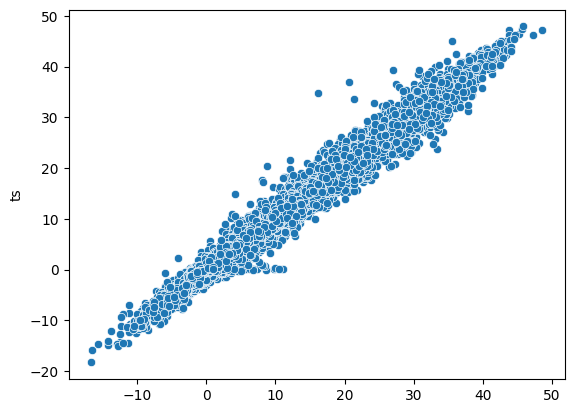

In [ ]:
X_train = X_train[original_features]
X_test = X_test[original_features]

model = CatBoostRegressor(random_state=42,silent=True, task_type='GPU')
model.fit(X_train, y_train)
pred = model.predict(X_test)
sns.scatterplot(x=pred, y=y_test)
final_spring_pred = model.predict(test_spring[original_features])

# 가을

In [ ]:
#계절별 훈련 데이터셋, 테스트 데이터셋 생성
train_spring = train[train['mmddhh'].isin(ss_spring['mmddhh'])]
test_spring = test[test['mmddhh'].isin(ss_spring['mmddhh'])]

#차분
for col in ['ss']:
    train_spring[col + '_diff_1'] = train_spring[col].diff()
    test_spring[col + '_diff_1'] = test_spring[col].diff()

#시차이동
for col in ['si','ta','ss']:
    train_spring[col + '_shift_1'] = train_spring[col].shift(1)
    test_spring[col + '_shift_1'] = test_spring[col].shift(1)

#
for col in ['ta','re']:
    train_spring[col + '_rolling'] = train_spring[col].rolling(window=24).mean()
    test_spring[col + '_rolling'] = test_spring[col].rolling(window=24).mean()

# #확장
for col in ['si','re','ws','rn','sn']:
    train_spring[col + '_expanding'] = train_spring[col].expanding(min_periods=24).mean()
    test_spring[col + '_expanding'] = test_spring[col].expanding(min_periods=24).mean()

# train_summer = train[train['mmddhh'].isin(ss_summer['mmddhh'])]
# # train_summer.fillna(train_summer[num_cols].median(axis=0), inplace=True)

# train_autumn = train[train['mmddhh'].isin(ss_autumn['mmddhh'])]
# # train_autumn.fillna(train_autumn[num_cols].median(axis=0), inplace=True)

# train_winter = train[train['mmddhh'].isin(ss_winter['mmddhh'])]
# # train_winter.fillna(train_winter[num_cols].median(axis=0), inplace=True)

# test_summer = test[test['mmddhh'].isin(ss_summer['mmddhh'])]
# test_summer = pd.merge(ss_summer, test_summer, on=['stn','year','mmddhh'])
# test_summer = test_summer.drop(['ts'],1)
# # test_summer.fillna(train_summer[num_cols].median(axis=0), inplace=True)

# test_autumn = test[test['mmddhh'].isin(ss_autumn['mmddhh'])]
# # test_autumn.fillna(train_autumn[num_cols].median(axis=0), inplace=True)

# test_winter = test[test['mmddhh'].isin(ss_winter['mmddhh'])]
# # test_winter.fillna(train_winter[num_cols].median(axis=0), inplace=True) #winter의 경우 vot model 을 사용한다.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
target = 'ts'
original_features = ['ta', 'si_shift_1', 'si', 'ta_shift_1', 'mmddhh', 'stn', 'month', 'year', 'hour', 'si_expanding', 're_expanding', 'ws_expanding', 'ss_diff_1', 'ss_shift_1', 'ta_rolling', 'rn_expanding', 'ss', 'td', 'sn_expanding', 're_rolling']
result_list = []
def spring_score_model(model, features_used, label=None):
    score_list = []
    oof = np.zeros_like(train_spring[target])
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    for fold, (idx_tr, idx_val) in enumerate(kf.split(train_spring[original_features], train_spring[target])):
        X_train_spring = train_spring.iloc[idx_tr][features_used]
        X_valid = train_spring.iloc[idx_val][features_used]
        y_train_spring = train_spring.iloc[idx_tr][target]
        y_valid = train_spring.iloc[idx_val][target]

        num_cols = X_train_spring.select_dtypes(exclude='object').columns.tolist()
        cat_cols = X_train_spring.select_dtypes(include='object').columns.tolist()

        encoding = LabelEncoder()

        for col in cat_cols:
            X_train_spring[col] = encoding.fit_transform(X_train_spring[col])
            X_valid[col] = encoding.transform(X_valid[col])

        model.fit(X_train_spring, y_train_spring)
        tscore = mean_absolute_error(y_train_spring, model.predict(X_train_spring))
        y_valid_pred = model.predict(X_valid)
        score = mean_absolute_error(y_valid, y_valid_pred)
        print(f" Fold {fold} : tscore = {tscore:.3f} score = {score:.3f}")
        oof[idx_val] = y_valid_pred
        score_list.append(score)

    score = sum(score_list) / len(score_list)
    print(f" Avg. MAE score : {score:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, score, oof))

XGB 과적합

In [ ]:
%%time
spring_score_model(CatBoostRegressor(random_state=42, silent=True, task_type='GPU'), features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.853 score = 0.903
 Fold 1 : tscore = 0.855 score = 0.896
 Fold 2 : tscore = 0.855 score = 0.911
 Fold 3 : tscore = 0.851 score = 0.896
 Fold 4 : tscore = 0.852 score = 0.904
 Fold 5 : tscore = 0.855 score = 0.900
 Fold 6 : tscore = 0.854 score = 0.893
 Fold 7 : tscore = 0.853 score = 0.902
 Fold 8 : tscore = 0.858 score = 0.891
 Fold 9 : tscore = 0.853 score = 0.900
 Avg. MAE score : 0.900
CPU times: user 59.3 s, sys: 23.1 s, total: 1min 22s
Wall time: 58.6 s


In [ ]:
%%time
#xgboost의 경우, 결측값 채우기전이 후보다 좋다
spring_score_model(XGBRegressor(random_state=42, tree_method='gpu_hist'), features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.816 score = 0.919
 Fold 1 : tscore = 0.835 score = 0.923
 Fold 2 : tscore = 0.830 score = 0.934
 Fold 3 : tscore = 0.824 score = 0.924
 Fold 4 : tscore = 0.830 score = 0.932
 Fold 5 : tscore = 0.830 score = 0.938
 Fold 6 : tscore = 0.825 score = 0.914
 Fold 7 : tscore = 0.825 score = 0.930
 Fold 8 : tscore = 0.831 score = 0.927
 Fold 9 : tscore = 0.830 score = 0.938
 Avg. MAE score : 0.928
CPU times: user 16.4 s, sys: 264 ms, total: 16.7 s
Wall time: 16.8 s


In [ ]:
from sklearn.ensemble import VotingRegressor

vot_model = VotingRegressor(estimators=[('XGBoost',XGBRegressor(random_state=42, tree_method='gpu_hist')),('CatBoost',CatBoostRegressor(random_state=42, silent=True,task_type='GPU'))])

In [ ]:
%%time
spring_score_model(vot_model, features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.795 score = 0.866
 Fold 1 : tscore = 0.810 score = 0.871
 Fold 2 : tscore = 0.804 score = 0.882
 Fold 3 : tscore = 0.799 score = 0.868
 Fold 4 : tscore = 0.802 score = 0.876
 Fold 5 : tscore = 0.804 score = 0.880
 Fold 6 : tscore = 0.801 score = 0.863
 Fold 7 : tscore = 0.800 score = 0.875
 Fold 8 : tscore = 0.805 score = 0.867
 Fold 9 : tscore = 0.801 score = 0.876
 Avg. MAE score : 0.873
CPU times: user 1min 19s, sys: 25.8 s, total: 1min 44s
Wall time: 1min 20s


In [ ]:
# test set 예측
encoding = LabelEncoder()

num_cols = train_spring[original_features].select_dtypes(exclude='object').columns.tolist()
cat_cols = train_spring[original_features].select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    train_spring[col] = encoding.fit_transform(train_spring[col])
    test_spring[col] = encoding.fit_transform(test_spring[col])

X = train_spring.drop(['ts'],1)
y = train_spring.ts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [ ]:
# model = CatBoostRegressor(random_state=42, silent=True, task_type='GPU')
# model.fit(X_train, y_train)

# def plot_feature_importance(importance, names, model_type, figsize=(10,8)):
#     feature_importance = np.array(importance)
#     feature_names = np.array(names)

#     data = {'feature_names':feature_names, 'feature_importance':feature_importance}
#     fi_df = pd.DataFrame(data)

#     fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#     plt.figure(figsize=figsize)

#     sns.barplot(x=fi_df['feature_importance'],y=fi_df['feature_names'])

#     plt.title(model_type + 'FEATURE IM..')
#     plt.xlabel("FEATURE IM..")
#     plt.ylabel('FEATURE NAME')

# plot_feature_importance(model.feature_importances_, X_train.columns, 'CAT',figsize=(8,16))

# importances = model.feature_importances_
# feature_names = X_train.columns


# feature_importances = pd.DataFrame({'Feature_names': feature_names, 'Importance': importances})


# sorted_df = feature_importances.sort_values(by='Importance', ascending=False)


# top_10_features = sorted_df.head(20)
# top_10_features_list = top_10_features['Feature_names'].tolist()

# print(top_10_features_list)

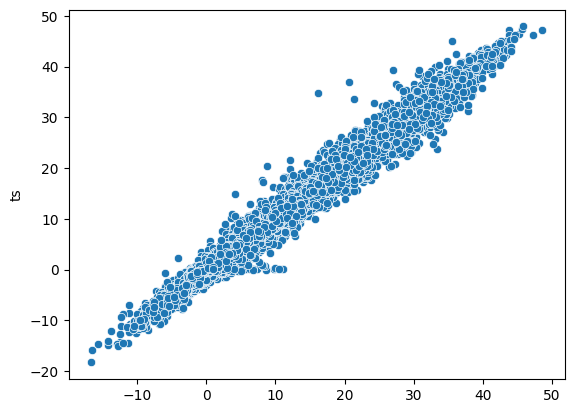

In [ ]:
X_train = X_train[original_features]
X_test = X_test[original_features]

model = CatBoostRegressor(random_state=42,silent=True, task_type='GPU')
model.fit(X_train, y_train)
pred = model.predict(X_test)
sns.scatterplot(x=pred, y=y_test)
final_spring_pred = model.predict(test_spring[original_features])

# 겨울

In [ ]:
#계절별 훈련 데이터셋, 테스트 데이터셋 생성
train_spring = train[train['mmddhh'].isin(ss_spring['mmddhh'])]
test_spring = test[test['mmddhh'].isin(ss_spring['mmddhh'])]

#차분
for col in ['ss']:
    train_spring[col + '_diff_1'] = train_spring[col].diff()
    test_spring[col + '_diff_1'] = test_spring[col].diff()

#시차이동
for col in ['si','ta','ss']:
    train_spring[col + '_shift_1'] = train_spring[col].shift(1)
    test_spring[col + '_shift_1'] = test_spring[col].shift(1)

#
for col in ['ta','re']:
    train_spring[col + '_rolling'] = train_spring[col].rolling(window=24).mean()
    test_spring[col + '_rolling'] = test_spring[col].rolling(window=24).mean()

# #확장
for col in ['si','re','ws','rn','sn']:
    train_spring[col + '_expanding'] = train_spring[col].expanding(min_periods=24).mean()
    test_spring[col + '_expanding'] = test_spring[col].expanding(min_periods=24).mean()

# train_summer = train[train['mmddhh'].isin(ss_summer['mmddhh'])]
# # train_summer.fillna(train_summer[num_cols].median(axis=0), inplace=True)

# train_autumn = train[train['mmddhh'].isin(ss_autumn['mmddhh'])]
# # train_autumn.fillna(train_autumn[num_cols].median(axis=0), inplace=True)

# train_winter = train[train['mmddhh'].isin(ss_winter['mmddhh'])]
# # train_winter.fillna(train_winter[num_cols].median(axis=0), inplace=True)

# test_summer = test[test['mmddhh'].isin(ss_summer['mmddhh'])]
# test_summer = pd.merge(ss_summer, test_summer, on=['stn','year','mmddhh'])
# test_summer = test_summer.drop(['ts'],1)
# # test_summer.fillna(train_summer[num_cols].median(axis=0), inplace=True)

# test_autumn = test[test['mmddhh'].isin(ss_autumn['mmddhh'])]
# # test_autumn.fillna(train_autumn[num_cols].median(axis=0), inplace=True)

# test_winter = test[test['mmddhh'].isin(ss_winter['mmddhh'])]
# # test_winter.fillna(train_winter[num_cols].median(axis=0), inplace=True) #winter의 경우 vot model 을 사용한다.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
target = 'ts'
original_features = ['ta', 'si_shift_1', 'si', 'ta_shift_1', 'mmddhh', 'stn', 'month', 'year', 'hour', 'si_expanding', 're_expanding', 'ws_expanding', 'ss_diff_1', 'ss_shift_1', 'ta_rolling', 'rn_expanding', 'ss', 'td', 'sn_expanding', 're_rolling']
result_list = []
def spring_score_model(model, features_used, label=None):
    score_list = []
    oof = np.zeros_like(train_spring[target])
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    for fold, (idx_tr, idx_val) in enumerate(kf.split(train_spring[original_features], train_spring[target])):
        X_train_spring = train_spring.iloc[idx_tr][features_used]
        X_valid = train_spring.iloc[idx_val][features_used]
        y_train_spring = train_spring.iloc[idx_tr][target]
        y_valid = train_spring.iloc[idx_val][target]

        num_cols = X_train_spring.select_dtypes(exclude='object').columns.tolist()
        cat_cols = X_train_spring.select_dtypes(include='object').columns.tolist()

        encoding = LabelEncoder()

        for col in cat_cols:
            X_train_spring[col] = encoding.fit_transform(X_train_spring[col])
            X_valid[col] = encoding.transform(X_valid[col])

        model.fit(X_train_spring, y_train_spring)
        tscore = mean_absolute_error(y_train_spring, model.predict(X_train_spring))
        y_valid_pred = model.predict(X_valid)
        score = mean_absolute_error(y_valid, y_valid_pred)
        print(f" Fold {fold} : tscore = {tscore:.3f} score = {score:.3f}")
        oof[idx_val] = y_valid_pred
        score_list.append(score)

    score = sum(score_list) / len(score_list)
    print(f" Avg. MAE score : {score:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, score, oof))

XGB 과적합

In [ ]:
%%time
spring_score_model(CatBoostRegressor(random_state=42, silent=True, task_type='GPU'), features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.853 score = 0.903
 Fold 1 : tscore = 0.855 score = 0.896
 Fold 2 : tscore = 0.855 score = 0.911
 Fold 3 : tscore = 0.851 score = 0.896
 Fold 4 : tscore = 0.852 score = 0.904
 Fold 5 : tscore = 0.855 score = 0.900
 Fold 6 : tscore = 0.854 score = 0.893
 Fold 7 : tscore = 0.853 score = 0.902
 Fold 8 : tscore = 0.858 score = 0.891
 Fold 9 : tscore = 0.853 score = 0.900
 Avg. MAE score : 0.900
CPU times: user 59.3 s, sys: 23.1 s, total: 1min 22s
Wall time: 58.6 s


In [ ]:
%%time
#xgboost의 경우, 결측값 채우기전이 후보다 좋다
spring_score_model(XGBRegressor(random_state=42, tree_method='gpu_hist'), features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.816 score = 0.919
 Fold 1 : tscore = 0.835 score = 0.923
 Fold 2 : tscore = 0.830 score = 0.934
 Fold 3 : tscore = 0.824 score = 0.924
 Fold 4 : tscore = 0.830 score = 0.932
 Fold 5 : tscore = 0.830 score = 0.938
 Fold 6 : tscore = 0.825 score = 0.914
 Fold 7 : tscore = 0.825 score = 0.930
 Fold 8 : tscore = 0.831 score = 0.927
 Fold 9 : tscore = 0.830 score = 0.938
 Avg. MAE score : 0.928
CPU times: user 16.4 s, sys: 264 ms, total: 16.7 s
Wall time: 16.8 s


In [ ]:
from sklearn.ensemble import VotingRegressor

vot_model = VotingRegressor(estimators=[('XGBoost',XGBRegressor(random_state=42, tree_method='gpu_hist')),('CatBoost',CatBoostRegressor(random_state=42, silent=True,task_type='GPU'))])

In [ ]:
%%time
spring_score_model(vot_model, features_used=original_features, label="CAT")

 Fold 0 : tscore = 0.795 score = 0.866
 Fold 1 : tscore = 0.810 score = 0.871
 Fold 2 : tscore = 0.804 score = 0.882
 Fold 3 : tscore = 0.799 score = 0.868
 Fold 4 : tscore = 0.802 score = 0.876
 Fold 5 : tscore = 0.804 score = 0.880
 Fold 6 : tscore = 0.801 score = 0.863
 Fold 7 : tscore = 0.800 score = 0.875
 Fold 8 : tscore = 0.805 score = 0.867
 Fold 9 : tscore = 0.801 score = 0.876
 Avg. MAE score : 0.873
CPU times: user 1min 19s, sys: 25.8 s, total: 1min 44s
Wall time: 1min 20s


In [ ]:
# test set 예측
encoding = LabelEncoder()

num_cols = train_spring[original_features].select_dtypes(exclude='object').columns.tolist()
cat_cols = train_spring[original_features].select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    train_spring[col] = encoding.fit_transform(train_spring[col])
    test_spring[col] = encoding.fit_transform(test_spring[col])

X = train_spring.drop(['ts'],1)
y = train_spring.ts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [ ]:
# model = CatBoostRegressor(random_state=42, silent=True, task_type='GPU')
# model.fit(X_train, y_train)

# def plot_feature_importance(importance, names, model_type, figsize=(10,8)):
#     feature_importance = np.array(importance)
#     feature_names = np.array(names)

#     data = {'feature_names':feature_names, 'feature_importance':feature_importance}
#     fi_df = pd.DataFrame(data)

#     fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#     plt.figure(figsize=figsize)

#     sns.barplot(x=fi_df['feature_importance'],y=fi_df['feature_names'])

#     plt.title(model_type + 'FEATURE IM..')
#     plt.xlabel("FEATURE IM..")
#     plt.ylabel('FEATURE NAME')

# plot_feature_importance(model.feature_importances_, X_train.columns, 'CAT',figsize=(8,16))

# importances = model.feature_importances_
# feature_names = X_train.columns


# feature_importances = pd.DataFrame({'Feature_names': feature_names, 'Importance': importances})


# sorted_df = feature_importances.sort_values(by='Importance', ascending=False)


# top_10_features = sorted_df.head(20)
# top_10_features_list = top_10_features['Feature_names'].tolist()

# print(top_10_features_list)

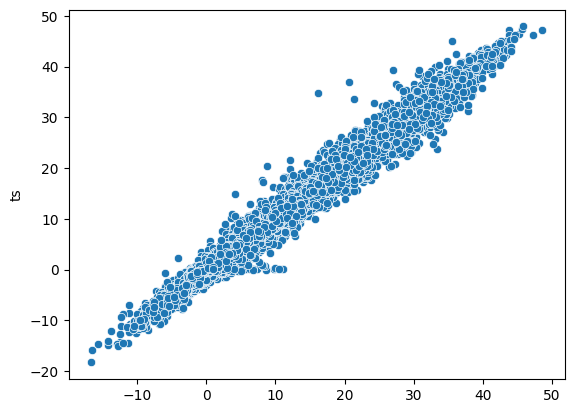

In [ ]:
X_train = X_train[original_features]
X_test = X_test[original_features]

model = CatBoostRegressor(random_state=42,silent=True, task_type='GPU')
model.fit(X_train, y_train)
pred = model.predict(X_test)
sns.scatterplot(x=pred, y=y_test)
final_spring_pred = model.predict(test_spring[original_features])

# 제출

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Weather/data/subminssionUser.xlsx'
output_file_path = '/content/drive/MyDrive/Weather/data/겨울결측치제거_봄여름extra_가을cat_겨울vot_median값_여름가을_sn_drop.xlsx'

seasons = ['SPRING', 'SUMMER', 'AUTUMN', 'WINTER']
preds = [final_spring_pred, final_summer_pred, final_autumn_pred, final_winter_pred]

with pd.ExcelWriter(output_file_path) as writer:
    for season, pred in zip(seasons, preds):
        df = pd.read_excel(file_path, sheet_name=season)
        df['TS'] = pred
        df.to_excel(writer, sheet_name=season, index=False)

print("예측값이 저장된 파일:", output_file_path)

예측값이 저장된 파일: /content/drive/MyDrive/Weather/data/겨울결측치제거_봄여름extra_가을cat_겨울vot_median값_여름가을_sn_drop.xlsx
